## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [129]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=0.0, alpha=0.01, max_epoch=10, penalty='L2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        penalty - выбор способа регуляризации (L1 или L2)
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.losses_list = []  # значение функции потерь для каждой эпохи
  

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X_b = np.c_[np.ones((len(X), 1)), X]  # добавляем к X столбец единиц
        y_b = y.reshape(-1, 1)  # делаем из y матрицу-столбец
        
        # Инициализируем веса модели (случайными числами)
        self.theta = np.random.randn(X_b.shape[1], 1)  # theta - матрица-столбец
            
        for epoch in range(self.max_epoch):
            self._SGD(X_b, y_b)
        
        return self   
  

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        # обновим веса без их повторной инициализации (стартуем с уже ранее найденных весов)
        X_b = np.c_[np.ones((len(X), 1)), X]
        y_b = y.reshape(-1, 1)
        
        self._SGD(X_b, y_b)     
            
        return self
        
        
    # стохастический градиентный спуск для одного прохода по тестовому набору
    def _SGD(self, X_b, y_b):
        m = len(X_b)
        
        # Случайно переставляем тренировочные данные
        p = np.random.permutation(m)
            
        for index in p:  # цикл по тренировочным данным
            # случайный тестовый образец
            xi = X_b[[index], :]  # xi - матрица-строка
            yi = y_b[[index], :]
                
            gradients = self._get_gradients(xi, yi)
                    
            # обновляем веса
            self.theta = self.theta - self.alpha * gradients  
            
        epoch_log_loss = self.loss_function(X_b, y_b)  # значение функции потерь на конец эпохи
        self.losses_list.append(epoch_log_loss)
        
        return self
    
    
    # поиск градиентов
    def _get_gradients(self, xi, yi):
        # столбец производных функции ошибки по theta_i 
        Z = xi.dot(self.theta)
        y_hat = 1.0 / (1.0 + np.exp(-1.0 * Z))
                
        gradients = 2 * xi.T.dot(y_hat - yi)
                
        # добавляем член, связанный с регуляризацией. Обновляем все theta кроме theta_0
        if self.penalty == 'L1':
            gradients[1:] += self.C * np.sign(self.theta[1:])  # |x|` == sign(x)
        if self.penalty == 'L2':
            gradients[1:] += 2 * self.C * self.theta[1:]
            
        return gradients
        
    
    # на входе X - матрица значений признаков n x k. На выходе - стоблец из n классов 0 или 1
    def predict(self, X):
        '''
        Возвращение метки класса
        '''    
        return np.where(self.predict_proba(X) >= 0.5, 1, 0)
    
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_b = np.c_[np.ones((len(X), 1)), X]
        z = X_b.dot(self.theta)
        
        return 1.0 / (1.0 + np.exp(-1.0 * z))  # вероятность отнесения к классу 1
    
    
    def loss_function(self, X_b, y_b):
        '''
        Возвращает значение функции потерь
        '''
        X = X_b[:, 1:]
        y = y_b[:, 0]
        
        fi = self.predict_proba(X_b[:, 1:])
        
        log_loss = np.sum(-y * np.log2(fi)[:, 0] - (1 - y) * np.log2(1 - fi)[:, 0])
        
        if self.penalty == 'L1':
            log_loss += self.C * np.sum(np.absolute(self.theta))
        if self.penalty == 'L2':
            log_loss += self.C * np.sum(self.theta**2)
        
        return log_loss

### Вспомогательная функция для рисования разделяющей границы модели (работающей с двумя признаками)

In [130]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=cmap(idx),
                   marker=markers[idx], label=cl)

## Проверка на синтетических данных

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

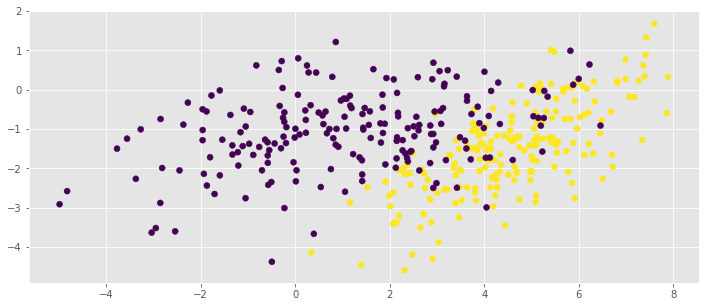

In [131]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X1 = np.vstack([gauss1, gauss2])
y1 = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X1[:,0], X1[:,1], c=y1)

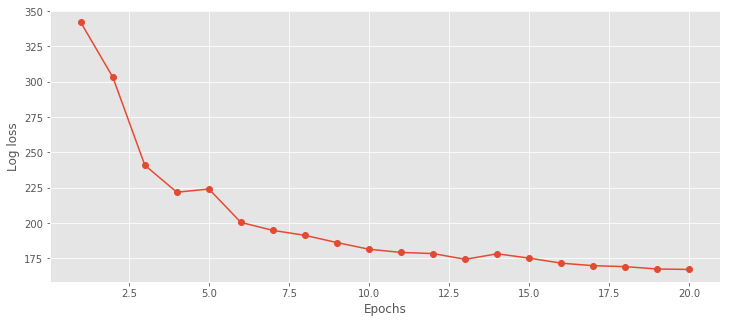

In [132]:
# обучаем модель
model1 = MySGDClassifier(max_epoch=20)
model1.fit(X1, y1)
plt.plot(range(1, len(model1.losses_list) + 1), model1.losses_list, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.show()

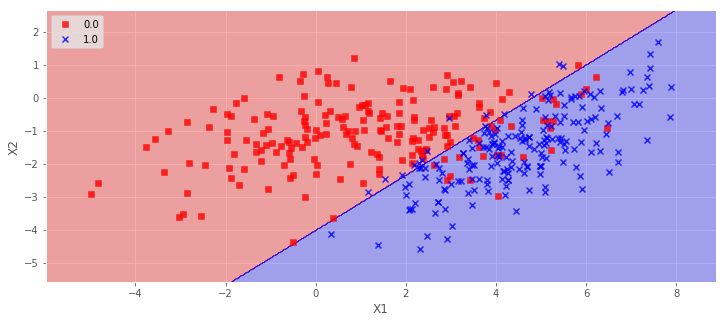

In [133]:
# изобразим разделяющую границу
plot_decision_regions(X1, y1, classifier=model1)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper left')
plt.show()

### Проверка на линейно разделимых данных

In [134]:
# Рассмотрим линейно разделимый случай - ирисы Фишера двух видов
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


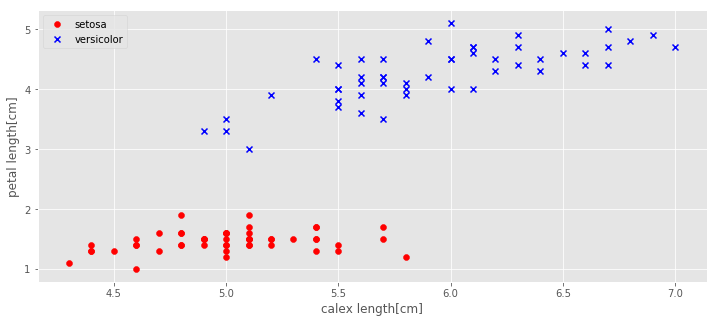

In [135]:
y2 = df.iloc[0:100, 4].values
y2 = np.where(y2 == 'Iris-setosa', 0, 1)
X2 = df.iloc[0:100, [0, 2]].values
plt.scatter(X2[:50, 0], X2[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X2[50:100, 0], X2[50:100, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('calex length[cm]')
plt.ylabel('petal length[cm]')
plt.legend(loc='upper left')
plt.show()

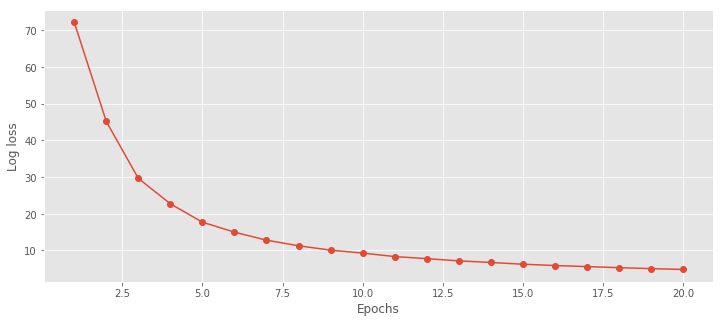

In [136]:
model2 = MySGDClassifier(max_epoch=20)
model2.fit(X2, y2)
plt.plot(range(1, len(model2.losses_list) + 1), model2.losses_list, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Log loss')
plt.show()

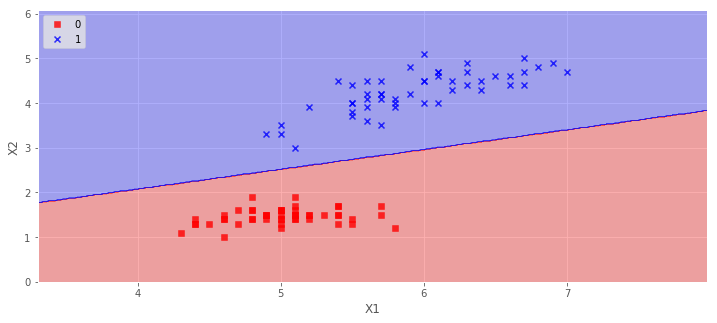

In [137]:
# изобразим разделяющую границу
plot_decision_regions(X2, y2, classifier=model2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='upper left')
plt.show()

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here